# Binary classification of commutative diagrams

In [1]:
#import torch
import os
import shutil
import random
import math
from copy import deepcopy

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.datasets import mnist
import tensorflow_addons as tfa # Needed for Yogi optimizer
tfa.register_all(custom_kernels=False) # Registers TFA objects in TF dictionaries
#%load_ext tensorboard
#%tensorboard --logdir TensorBoardLogs/
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

## 1. Data pipeline

### 1.1 Expand working directory with train, test and validation folders

In [2]:
##
unsortedSamplesDirName = 'diagramSamplesMarch25'
##

cwd = os.getcwd()

unsortedSamplesDir = os.path.join(cwd, unsortedSamplesDirName)
assert('positive' in os.listdir(unsortedSamplesDir) and 'negative' in os.listdir(unsortedSamplesDir))
unsortedPositiveSamplesDir = os.path.join(unsortedSamplesDir, 'positive')
unsortedNegativeSamplesDir = os.path.join(unsortedSamplesDir, 'negative')

sortedSamplesDir = os.path.join(cwd, 'sortedSamples')
os.makedirs(sortedSamplesDir, exist_ok=True)

trainDir = os.path.join(sortedSamplesDir, 'train')
testDir = os.path.join(sortedSamplesDir, 'test')
valDir = os.path.join(sortedSamplesDir, 'val')
os.makedirs(trainDir, exist_ok=True)
os.makedirs(testDir, exist_ok=True)
os.makedirs(valDir, exist_ok=True)

trainPositiveDir = os.path.join(trainDir, 'positive')
trainNegativeDir = os.path.join(trainDir, 'negative')
testPositiveDir = os.path.join(testDir, 'positive')
testNegativeDir = os.path.join(testDir, 'negative')
valPositiveDir = os.path.join(valDir, 'positive')
valNegativeDir = os.path.join(valDir, 'negative')
os.makedirs(trainPositiveDir, exist_ok=True)
os.makedirs(trainNegativeDir, exist_ok=True)
os.makedirs(testPositiveDir, exist_ok=True)
os.makedirs(testNegativeDir, exist_ok=True)
os.makedirs(valPositiveDir, exist_ok=True)
os.makedirs(valNegativeDir, exist_ok=True)

### 1.2 Copy images into folders
The code currently randomly truncates the greater partition between positive and negative to achieve parity.

In [3]:
##
trainRatio = 0.6
testRatio = 0.2
valRatio = 0.2
assert(trainRatio + testRatio + valRatio == 1.)

positiveRatio = 0.5 # Desired ratio of positive samples in the sorted data

performCopy = False
##

if performCopy:
    positiveSamplesFilenameList = os.listdir(unsortedPositiveSamplesDir)
    negativeSamplesFilenameList = os.listdir(unsortedNegativeSamplesDir)
    random.shuffle(positiveSamplesFilenameList)
    random.shuffle(negativeSamplesFilenameList)
    numPositiveSamples = len(positiveSamplesFilenameList)
    numNegativeSamples = len(negativeSamplesFilenameList)

    if numPositiveSamples > numNegativeSamples:
        positiveSamplesFilenameList = positiveSamplesFilenameList[:numNegativeSamples]
        numPositiveSamples = len(positiveSamplesFilenameList)
    elif numNegativeSamples > numPositiveSamples:
        negativeSamplesFilenameList = negativeSamplesFilenameList[:numPositiveSamples]
        numNegativeSamples = len(negativeSamplesFilenameList)
    assert(numPositiveSamples == numNegativeSamples)

    numSamples = numPositiveSamples + numNegativeSamples

    numTrainSamples = math.floor(numSamples*trainRatio)
    numTestSamples = math.floor(numSamples*testRatio)
    numValSamples = math.floor(numSamples*valRatio)


    unsortedSamplesInfo = {'posDir':unsortedPositiveSamplesDir, 'negDir':unsortedNegativeSamplesDir, 'posFilenameList':positiveSamplesFilenameList,
                           'negFilenameList':negativeSamplesFilenameList}

    trainCopyInfo = {'num':numTrainSamples, 'posDir':trainPositiveDir, 'negDir':trainNegativeDir}
    testCopyInfo = {'num':numTestSamples, 'posDir':testPositiveDir, 'negDir':testNegativeDir}
    valCopyInfo = {'num':numValSamples, 'posDir':valPositiveDir, 'negDir':valNegativeDir}

    def copyImagesInPartition(unsortedSamplesInfo:dict, partitionCopyInfo:dict):
        for _ in range(math.floor(partitionCopyInfo['num']*positiveRatio)):
            copyImage(unsortedSamplesInfo['posFilenameList'], unsortedSamplesInfo['posDir'], partitionCopyInfo['posDir'])
        for _ in range(math.floor(partitionCopyInfo['num']*(1. - positiveRatio))):
            copyImage(unsortedSamplesInfo['negFilenameList'], unsortedSamplesInfo['negDir'], partitionCopyInfo['negDir'])

    def copyImage(sampleFilenameList, srcDir, dstDir):
        filename = sampleFilenameList.pop()
        src = os.path.join(srcDir, filename)
        dst = os.path.join(dstDir, filename)
        try:
            shutil.copyfile(src, dst)
        except PermissionError: # Ignores straggler files such as notebook checkpoints
            pass

    sampleDirectorySizes = [len(directory) for directory in [
        os.listdir(trainPositiveDir), os.listdir(trainNegativeDir), os.listdir(testPositiveDir), os.listdir(testNegativeDir),
        os.listdir(testPositiveDir), os.listdir(testNegativeDir)]]

    if all(size == 0 for size in sampleDirectorySizes):
        copyImagesInPartition(unsortedSamplesInfo, trainCopyInfo)
        copyImagesInPartition(unsortedSamplesInfo, testCopyInfo)
        copyImagesInPartition(unsortedSamplesInfo, valCopyInfo)
    else:
        raise Exception("Sorted image directories are not empty.")

[*Optional*]: Test whether a sample handful of the images were copied to the correct folders

In [4]:
##
runImageCopyTest = False

comparisonSampleSize = 50
imageFiletype = 'png'
##

if runImageCopyTest and performCopy:
    # These must be redefined here since they were popped
    positiveSamplesFilenameList = os.listdir(unsortedPositiveSamplesDir)
    negativeSamplesFilenameList = os.listdir(unsortedNegativeSamplesDir)

    sortedTrainPositiveFilenameList = os.listdir(trainPositiveDir)
    sortedTrainNegativeFilenameList = os.listdir(trainNegativeDir)
    sortedTestPositiveFilenameList = os.listdir(testPositiveDir)
    sortedTestNegativeFilenameList = os.listdir(testNegativeDir)
    sortedValPositiveFilenameList = os.listdir(valPositiveDir)
    sortedValNegativeFilenameList = os.listdir(valNegativeDir)
    random.shuffle(sortedTrainPositiveFilenameList)
    random.shuffle(sortedTrainNegativeFilenameList)
    random.shuffle(sortedTestPositiveFilenameList)
    random.shuffle(sortedTestNegativeFilenameList)
    random.shuffle(sortedValPositiveFilenameList)
    random.shuffle(sortedValNegativeFilenameList)

    allPositiveFilenameLists = [sortedTrainPositiveFilenameList, sortedTestPositiveFilenameList, sortedValPositiveFilenameList]
    allNegativeFilenameLists = [sortedTrainNegativeFilenameList, sortedTestNegativeFilenameList, sortedValNegativeFilenameList]

    def matchesImageFiletype(sampleFilename : str, imageFiletype : str): # Needed to ignore straggler files such as notebook checkpoints
        return sampleFilename[:len(imageFiletype)] == imageFiletype

    for fList in allPositiveFilenameLists:
        assert(all(sampleFilename in positiveSamplesFilenameList
                   for sampleFilename in fList[:comparisonSampleSize]
                   if matchesImageFiletype(sampleFilename, imageFiletype)))
    for fList in allNegativeFilenameLists:
        assert(all(sampleFilename in negativeSamplesFilenameList
                   for sampleFilename in fList[:comparisonSampleSize]
                   if matchesImageFiletype(sampleFilename, imageFiletype)))
    print('Test was succesful!')

### 1.3 Data generators

The data generators themselves can rescale the input pixel values to the [0, 1] range and convert to grayscale. Note that the EfficientNet baseline models expect 3D pixel floats in the [0-255] range. Thus, a seperate set of data generators is made for them.

In [5]:
##
batchSize = 75
imageResolution = (203, 203) # (299, 299) Chosen based on anecdote in EfficientNet paper
##

trainDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valDataGenerator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

trainDataGenerator = trainDataGeneratorFactory.flow_from_directory( # Batch generator
    trainDir,
    target_size = imageResolution,
    batch_size = batchSize,
    color_mode = 'grayscale',
    class_mode = 'binary')
testDataGenerator = testDataGeneratorFactory.flow_from_directory(
    testDir,
    target_size = imageResolution,
    batch_size = batchSize,
    color_mode = 'grayscale',
    class_mode = 'binary')
valDataGenerator = testDataGeneratorFactory.flow_from_directory(
    valDir,
    target_size = imageResolution,
    batch_size = batchSize,
    color_mode = 'grayscale',
    class_mode = 'binary')


efficientNetTrainDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()
efficientNetTestDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()
efficientNetValDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()

efficientNetTrainDataGenerator = efficientNetTrainDataGeneratorFactory.flow_from_directory( # Batch generator
    trainDir,
    target_size = imageResolution,
    batch_size = batchSize,
    class_mode = 'binary')
efficientNetTestDataGenerator = efficientNetTestDataGeneratorFactory.flow_from_directory(
    testDir,
    target_size = imageResolution,
    batch_size = batchSize,
    class_mode = 'binary')
efficientNetValDataGenerator = efficientNetValDataGeneratorFactory.flow_from_directory(
    valDir,
    target_size = imageResolution,
    batch_size = batchSize,
    class_mode = 'binary')

Found 1292 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 1292 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 430 images belonging to 2 classes.


## 2 Baseline models implementation
A series of baseline models are implemented for comparative study.
- A simple vanilla CNN model with a standard architecture
- Pretrained EfficientNet as feature extraction
- Finetuned pretrained EfficientNet
- EfficientNet manually trained on MNIST

Note that compiling the finetuned EfficientNet or the MNIST EfficientNet requires a feature extractor, and the process will fail if no saved model exists and compilation of the feature extractor is off.

In [6]:
##
compileBaselineCNN = False
compileEfficientNetFE = False
compileFinetunedEfficientNet = False
compileMNISTEfficientNet = True
##

if compileFinetunedEfficientNet:
    compileEfficientNetFE = True
if compileEfficientNetFE or compileMNISTEfficientNet:
    extractFeatures = True
else:
    extractFeatures = False
    assert(compileEfficientNetFE)

#### 2.1.1 Building baseline CNN

In [7]:
baselineCNN = models.Sequential(name='BaselineCNN')
baselineCNN.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*imageResolution, 1)))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Flatten())
baselineCNN.add(layers.Dropout(0.5))
baselineCNN.add(layers.Dense(512, activation='relu'))
baselineCNN.add(layers.Dense(1, activation='sigmoid'))
#baselineCNN.summary()

#### 2.1.2 EfficientNet bases

In [8]:
efficientNetMinInputShape = (32, 32, 1)
# MNISTInputShape = (28, 28, 1)

# Pretrained EfficientNet
efficientNetB1Base = keras.applications.efficientnet.EfficientNetB1(
    include_top = False,
    input_shape = (*imageResolution, 3),
    # Try with pooling='avg'/'max'?
    weights = 'imagenet')
efficientNetB1Base.trainable = False

# For MNIST
untrainedEfficientNetB1Base = keras.applications.efficientnet.EfficientNetB1(
    include_top = False,
    input_shape = efficientNetMinInputShape,
    weights = None)

efficientNetBaseOutputShape = efficientNetB1Base.output_shape[1:]
efficientNetBaseFlatOutputSize = np.product(efficientNetBaseOutputShape)
efficientNetMNISTBaseOutputShape = untrainedEfficientNetB1Base.output_shape[1:]
efficientNetMNISTBaseFlatOutputSize = np.product(efficientNetMNISTBaseOutputShape)
#efficientNetBaseFlatOutputSizeGrayscale = np.product(efficientNetBaseOutputShape[1:-1])

#### 2.1.3 Classifier for pretrained EfficientNet

In [9]:
efficientNetB1FEClassifier = models.Sequential(name='efficientNetB1FEClassifier')
#efficientNetB1FEClassifier.add(layers.Dense(1024, activation='relu', input_dim=efficientNetBaseFlatOutputSize))
efficientNetB1FEClassifier.add(layers.Dense(256, activation='relu', input_dim=efficientNetBaseFlatOutputSize))
efficientNetB1FEClassifier.add(layers.Dropout(0.5))
efficientNetB1FEClassifier.add(layers.Dense(1, activation='sigmoid'))

#### 2.1.4 Classifiers for MNIST EfficientNet
Two classifiers are built. The "categorical classifier", for training on MNIST, with output length of 10, and the "binary classifier", for training and use on our binary dataset.

In [10]:
efficientNetB1MNISTCategoricalClassifier = models.Sequential(name='efficientNetB1MNISTCategoricalClassifier')
efficientNetB1MNISTCategoricalClassifier.add(layers.Dense(1024, activation='relu', input_dim=efficientNetMNISTBaseFlatOutputSize))
efficientNetB1MNISTCategoricalClassifier.add(layers.Dense(256, activation='relu')) 
efficientNetB1MNISTCategoricalClassifier.add(layers.Dropout(0.5))
efficientNetB1MNISTCategoricalClassifier.add(layers.Dense(10, activation='softmax'))

efficientNetB1MNISTBinaryClassifier = models.Sequential(name='efficientNetB1MNISTBinaryClassifier')
efficientNetB1MNISTBinaryClassifier.add(layers.Dense(1024, activation='relu', input_dim=efficientNetMNISTBaseFlatOutputSize)) # Should this be efficientNetBaseFlatOutputSize?
efficientNetB1MNISTBinaryClassifier.add(layers.Dense(256, activation='relu')) 
efficientNetB1MNISTBinaryClassifier.add(layers.Dropout(0.5))
efficientNetB1MNISTBinaryClassifier.add(layers.Dense(1, activation='sigmoid'))

#### 2.2.1 Feature extraction function

In [11]:
def extractFeatures(model, generator, modelOutputShape:tuple, numSamples=None):
    if not numSamples:
        numSamples = generator.n
    if numSamples % batchSize != 0:
        numSamples -= (numSamples % batchSize)
    features = np.zeros(shape=(numSamples, *modelOutputShape))
    labels = np.zeros(shape=(numSamples))
    i = 0
    for inputBatch, labelBatch in generator:
        featureBatch = model.predict(inputBatch)
        features[i*batchSize : (i + 1)*batchSize] = featureBatch
        labels[i*batchSize : (i + 1)*batchSize] = labelBatch
        i += 1
        if i*batchSize >= numSamples:
            break
    return features, labels

#### 2.2.2 Pretrained EfficientNet feature extraction

In [12]:
if extractFeatures:
    efficientNetTrainFeatures, efficientNetTrainLabels = extractFeatures(efficientNetB1Base, efficientNetTrainDataGenerator, efficientNetBaseOutputShape)
    efficientNetTestFeatures, efficientNetTestLabels = extractFeatures(efficientNetB1Base, efficientNetTestDataGenerator, efficientNetBaseOutputShape)
    efficientNetValFeatures, efficientNetValLabels = extractFeatures(efficientNetB1Base, efficientNetValDataGenerator, efficientNetBaseOutputShape)

    efficientNetTrainFeatures = np.reshape(efficientNetTrainFeatures, (efficientNetTrainFeatures.shape[0], efficientNetBaseFlatOutputSize))
    efficientNetTestFeatures = np.reshape(efficientNetTestFeatures, (efficientNetTestFeatures.shape[0], efficientNetBaseFlatOutputSize))
    efficientNetValFeatures = np.reshape(efficientNetValFeatures, (efficientNetValFeatures.shape[0], efficientNetBaseFlatOutputSize))

    flattenedEfficientNetFeatureShape = efficientNetTrainFeatures.shape

### 2.3 Compilation of baseline models

In [13]:
##
useTensorBoard = False

metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.BinaryCrossentropy(), keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
metricNames = ['binary accuracy', 'binary cross entropy', 'AUC', 'precision', 'recall']

epochs = 40

baselineCNNSavedModelName = 'baselineCNNSavedModel'
efficientNetFESavedModelName = 'efficientNetFESavedModel'
finetunedEfficientNetSavedModelName = 'finetunedEfficientNetSavedModel'
MNISTEfficientNetSavedModelName = 'MNISTEfficientNet' # This will be the name of the final model

finetuningLearningRate = 1e-5
finetuningLearningRateMNIST = 1e-4
layersToUnfreeze = ['top_conv', 'block7a_project_conv', 'block7a_dwconv']
##

filesInCwd = os.listdir(cwd)
if useTensorBoard:
    tensorBoardCallback = keras.callbacks.TensorBoard(log_dir='TensorBoardLogs', histogram_freq=1, embeddings_freq=1)
else:
    tensorboardCallback = None

#### 2.3.1 Baseline CNN

In [14]:
if compileBaselineCNN:
    baselineCNN.compile(optimizer=tfa.optimizers.Yogi(),
                        loss='binary_crossentropy',
                        metrics=metrics)
    baselineCNNHistory = baselineCNN.fit(trainDataGenerator,
                                         epochs=epochs,
                                         batch_size=batchSize,
                                         validation_data=valDataGenerator,
                                         callbacks=[tensorBoardCallback])
    baselineCNN.save(baselineCNNSavedModelName)
    keras.utils.plot_model(baselineCNN,
                           to_file='baselineCNN.jpg',
                           show_shapes=True)
elif baselineCNNSavedModelName in filesInCwd:
    baselineCNN = models.load_model(baselineCNNSavedModelName)
    baselineCNN.compile(optimizer=tfa.optimizers.Yogi(),
                        loss='binary_crossentropy',
                        metrics=metrics)

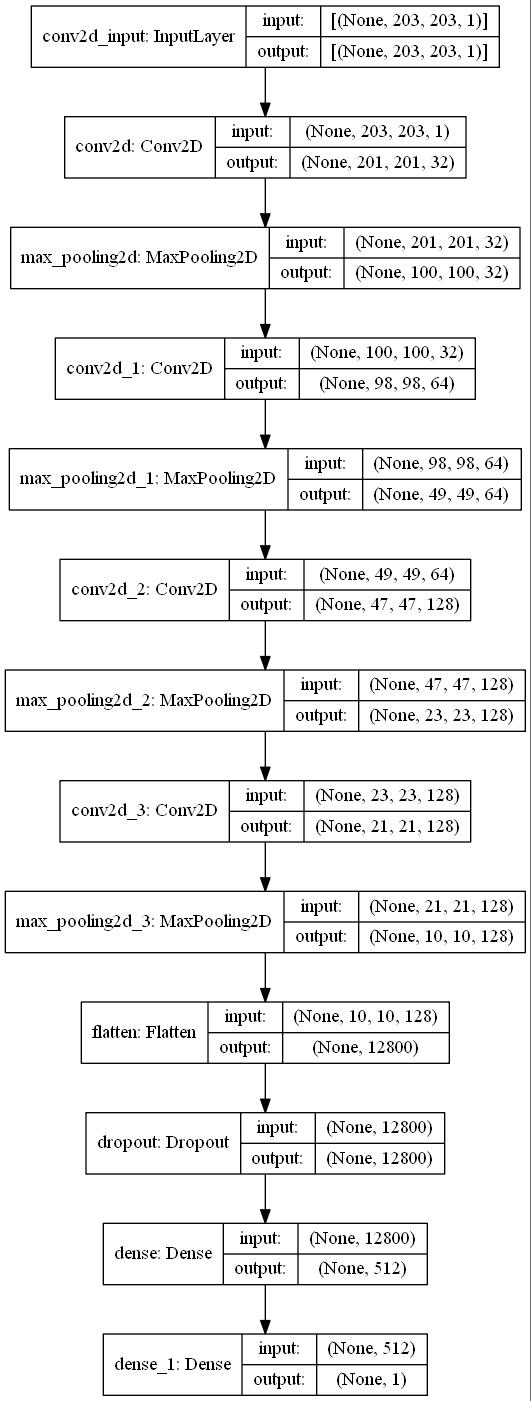

In [15]:
keras.utils.plot_model(baselineCNN,
                           to_file='baselineCNN.jpg',
                           show_shapes=True)

#### 2.3.2 EfficientNet feature extraction classifier

In [16]:
if compileEfficientNetFE:
    efficientNetB1FEClassifier.compile(optimizer=tfa.optimizers.Yogi(),
                                       loss='binary_crossentropy',
                                       metrics=metrics)
    efficientNetB1FEClassifierHistory = efficientNetB1FEClassifier.fit(efficientNetTrainFeatures, efficientNetTrainLabels,
                                                                       epochs=epochs,
                                                                       batch_size=batchSize,
                                                                       validation_data=(efficientNetValFeatures, efficientNetValLabels),
                                                                       callbacks=[tensorBoardCallback])
    efficientNetB1FEClassifier.save(efficientNetFESavedModelName)
    keras.utils.plot_model(efficientNetB1FEClassifier,
                           to_file='efficientNetB1FEClassifier.jpg',
                           show_shapes=True)
elif efficientNetFESavedModelName in filesInCwd:
    efficientNetB1FEClassifier = models.load_model(efficientNetFESavedModelName)
    efficientNetB1FEClassifier.compile(optimizer=tfa.optimizers.Yogi(),
                                       loss='binary_crossentropy',
                                       metrics=metrics)

#### 2.3.3 Finetuned EfficientNet

In [17]:
##
if compileFinetunedEfficientNet:
    trainableEfficientNetB1Base = efficientNetB1Base
    trainableEfficientNetB1Base.trainable = True
    for layer in trainableEfficientNetB1Base.layers:
        if layer.name not in layersToUnfreeze:
            layer.trainable = False

    finetunedEfficientNetB1 = models.Sequential(name='finetunedEfficientNetB1')
    finetunedEfficientNetB1.add(trainableEfficientNetB1Base)
    finetunedEfficientNetB1.add(layers.Flatten())
    finetunedEfficientNetB1.add(efficientNetB1FEClassifier) # Note that this is already trained
    #finetunedEfficientNetB1.summary()

    finetunedEfficientNetB1.compile(optimizer=tfa.optimizers.Yogi(learning_rate=finetuningLearningRate),
                                    loss='binary_crossentropy',
                                    metrics=metrics)
    finetunedEfficientNetB1History = finetunedEfficientNetB1.fit(efficientNetTrainDataGenerator,
                                                                 epochs=epochs,
                                                                 batch_size=batchSize,
                                                                 validation_data=efficientNetValDataGenerator,
                                                                 callbacks=[tensorBoardCallback])
    finetunedEfficientNetB1.save(finetunedEfficientNetSavedModelName)
    keras.utils.plot_model(finetunedEfficientNetB1,
                           to_file='finetunedEfficientNetB1.jpg',
                           show_shapes=True)
elif finetunedEfficientNetSavedModelName in filesInCwd:
    finetunedEfficientNetB1 = models.load_model(finetunedEfficientNetSavedModelName)
    finetunedEfficientNetB1.compile(optimizer=tfa.optimizers.Yogi(learning_rate=finetuningLearningRate),
                                    loss='binary_crossentropy',
                                    metrics=metrics)

#### 2.3.4 MNIST EfficientNet  
Since these models take much longer to train than any of the other models, I restrict a checkpoint-based *trainOrResumeTraining* function to these models to avoid unnecessary checkpoint bookkeeping clutter. This also means the intermediate models are saved as seperate models with their own training histories, provided they are trained in one go.

In [18]:
def trainOrResumeTrainingMNIST(model, samplesOrGenerator, epochs, labels=None, modelName=None, validationData=None):
    if modelName is None:
        modelName = model.name
    
    if modelName + 'SavedModel' in filesInCwd:
        print(f'Found fully trained model for {modelName}.')
        model.load_weights(modelName + 'SavedModel')
        history = None
        pass
    else:
        ckptsDir = os.path.join(cwd, 'checkpoints')
        modelCkptDir = os.path.join(ckptsDir, modelName)

        checkpointCallback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(modelCkptDir, '{epoch}'), save_weights_only=True)

        CkptsAvailable = 'checkpoints' in os.listdir(cwd) and modelName in os.listdir(ckptsDir)
        if CkptsAvailable:
            epochNums = (int(filename.split('.')[0]) for filename in os.listdir(modelCkptDir) if filename.split('.')[0].isdigit())
            resumingEpoch = max(epochNums)
            assert(resumingEpoch < epochs)
            ckptPath = os.path.join(modelCkptDir, str(resumingEpoch))
            model.load_weights(ckptPath)
            print(f'Found checkpoint for {modelName}. Resuming training from epoch {resumingEpoch + 1}')
            history = model.fit(samplesOrGenerator, 
                                labels,
                                initial_epoch=resumingEpoch,
                                epochs=epochs, 
                                batch_size=batchSize, 
                                callbacks=[checkpointCallback, tensorBoardCallback],
                                validation_data=validationData)
        else:        
            print(f'Did not find checkpoint for {modelName}. Training from scratch.')
            history = model.fit(samplesOrGenerator, 
                                labels, 
                                epochs=epochs, 
                                batch_size=batchSize, 
                                callbacks=[checkpointCallback, tensorBoardCallback],
                                validation_data=validationData)
        model.save(modelName + 'SavedModel')
        keras.utils.plot_model(model,
                               to_file='modelName.jpg',
                               show_shapes=True)
    return history 

Since EfficientNet has a minimum input shape of 32x32, the MNIST images of size 28x28 are padded with 4 background pixels (which are of value 0 in MNIST) on each spatial axis.  
Additionally, a "subbase" under the EfficientNet model base is added once the model must be trained on our dataset for downscaling input from 150x150 to 32x32.

In [22]:
##
MNISTTrainEpochs = 5 # For training the base
##

if compileMNISTEfficientNet:
    # Compile and train EfficientNet model on MNIST
    MNISTEfficientNetB1Categorical = models.Sequential(name='MNISTEfficientNetB1Categorical')
    MNISTEfficientNetB1Categorical.add(untrainedEfficientNetB1Base)
    MNISTEfficientNetB1Categorical.add(layers.Flatten())
    MNISTEfficientNetB1Categorical.add(efficientNetB1MNISTCategoricalClassifier)
    
    (MNISTTrainImages, MNISTTrainLabels), (MNISTTestImages, MNISTTestLabels) = mnist.load_data()
    
    MNISTTrainImages = MNISTTrainImages.astype('float32') / 255
    MNISTTestImages = MNISTTestImages.astype('float32') / 255
    
    
    # Transform to conform to minimum input size by padding with 4 background pixels on each spatial axis (2 before and after)
    MNISTTrainImages = np.pad(MNISTTrainImages, pad_width=((0, 0), (2, 2), (2,2)), constant_values=(0., 0.))
    MNISTTestImages = np.pad(MNISTTestImages, pad_width=((0,0), (2,2), (2,2)), constant_values=(0., 0.))
    
    MNISTTrainLabels = keras.utils.to_categorical(MNISTTrainLabels)
    MNISTTestLabels = keras.utils.to_categorical(MNISTTestLabels)
    
    MNISTEfficientNetB1Categorical.compile(optimizer=tfa.optimizers.Yogi(),
                               loss='categorical_crossentropy',
                               metrics=metrics) # Can be removed if desired
    
    MNISTEfficientNetB1CategoricalHistory = trainOrResumeTrainingMNIST(MNISTEfficientNetB1Categorical,
                                                                       MNISTTrainImages, 
                                                                       labels=MNISTTrainLabels, 
                                                                       epochs=MNISTTrainEpochs)
    
    
    # Freeze base and add binary classifier head
    MNISTEfficientNetB1Binary = models.Sequential(name='MNISTEfficientNetB1Binary')

    # Architecture for downsampling from (150, 150, 3) to (32, 32, 1)
    # Maybe we should increase maxpool window size?
    MNISTEfficientNetB1Binary.add(layers.MaxPool2D(pool_size=(2, 2), padding='same', input_shape=(*imageResolution, 3))) # Output shape = (102, 102, 3)
    MNISTEfficientNetB1Binary.add(layers.Conv2D(1, 5, strides=(2, 2), padding='same', activation = 'relu')) # Output shape = (51, 51)
    MNISTEfficientNetB1Binary.add(layers.Conv2D(1, 5, padding='valid', activation = 'relu')) # Output shape = (47, 47)
    MNISTEfficientNetB1Binary.add(layers.Conv2D(1, 5, padding='valid', activation = 'relu')) # Output shape = (43, 43)
    MNISTEfficientNetB1Binary.add(layers.Conv2D(1, 5, padding='valid', activation = 'relu')) # Output shape = (39, 39)
    MNISTEfficientNetB1Binary.add(layers.Conv2D(1, 4, padding='valid', activation = 'relu')) # Output shape = (36, 36)
    MNISTEfficientNetB1Binary.add(layers.Conv2D(1, 3, padding='valid', activation = 'relu')) # Output shape = (34, 34)
    MNISTEfficientNetB1Binary.add(layers.Conv2D(1, 3, padding='valid', activation = 'relu')) # Output shape = (32, 32)
    #
    #MNISTEfficientNetB1Binary.summary()
                                  
    trainedEfficientNetB1Base = untrainedEfficientNetB1Base
    trainedEfficientNetB1Base.trainable = False
    
    MNISTEfficientNetB1Binary.add(trainedEfficientNetB1Base)
    MNISTEfficientNetB1Binary.add(layers.Flatten())
    MNISTEfficientNetB1Binary.add(efficientNetB1MNISTBinaryClassifier)
    #MNISTEfficientNetB1Binary.summary()
    
    # Compile and train the model
    MNISTEfficientNetB1Binary.compile(optimizer=tfa.optimizers.Yogi(learning_rate=finetuningLearningRateMNIST),
                                       loss='binary_crossentropy',
                                       metrics=metrics)
    
    MNISTEfficientNetB1BinaryClassifierHistory = trainOrResumeTrainingMNIST(MNISTEfficientNetB1Binary,
                                                                            efficientNetTrainDataGenerator,
                                                                            modelName='MNISTBinaryFrozenBase',
                                                                            validationData=efficientNetValDataGenerator,
                                                                            epochs=epochs)
    
    
    # Finetuning with a few unfrozen top layers. Note that this is the same model object but this version is named 'MNISTBinaryHotBase' for checkpoints rather than
    # 'MNISTBinaryFrozenBase'
    trainedEfficientNetB1Base.trainable = True
    for layer in trainedEfficientNetB1Base.layers:
        if layer.name not in layersToUnfreeze:
            layer.trainable = False
    
    MNISTEfficientNetB1Binary.compile(optimizer=tfa.optimizers.Yogi(learning_rate=finetuningLearningRateMNIST),
                                       loss='binary_crossentropy',
                                       metrics=metrics)
    MNISTEfficientNetB1BinaryHistory = trainOrResumeTrainingMNIST(MNISTEfficientNetB1Binary,
                                                                  efficientNetTrainDataGenerator,
                                                                  modelName = 'MNISTBinaryHotBase',
                                                                  validationData=efficientNetValDataGenerator,
                                                                  epochs=epochs)
    MNISTEfficientNetB1Binary.save(MNISTEfficientNetSavedModelName)
    keras.utils.plot_model(MNISTEfficientNetB1Binary,
                           to_file='MNISTEfficientNetB1Binary.jpg',
                           show_shapes=True)
elif MNISTEfficientNetSavedModelName in filesInCwd:
    MNISTEfficientNetB1Binary = models.load_model(MNISTEfficientNetSavedModelName)
    MNISTEfficientNetB1Binary.compile(optimizer=tfa.optimizers.Yogi(learning_rate=finetuningLearningRateMNIST),
                                       loss='binary_crossentropy',
                                       metrics=metrics)

Found fully trained model for MNISTEfficientNetB1Categorical.
Did not find checkpoint for MNISTBinaryFrozenBase. Training from scratch.
Epoch 1/40
18/18 [==============================] - 43s 2s/step - loss: 0.6712 - binary_accuracy: 0.5759 - binary_crossentropy: 0.6712 - auc: 0.6458 - precision: 0.5992 - recall: 0.4582 - val_loss: 0.6574 - val_binary_accuracy: 0.6140 - val_binary_crossentropy: 0.6574 - val_auc: 0.6995 - val_precision: 0.6738 - val_recall: 0.4419
Epoch 2/40
18/18 [==============================] - 15s 819ms/step - loss: 0.6475 - binary_accuracy: 0.5975 - binary_crossentropy: 0.6475 - auc: 0.7152 - precision: 0.6658 - recall: 0.3916 - val_loss: 0.6436 - val_binary_accuracy: 0.6442 - val_binary_crossentropy: 0.6436 - val_auc: 0.7529 - val_precision: 0.7422 - val_recall: 0.4419
Epoch 3/40
18/18 [==============================] - 15s 813ms/step - loss: 0.6389 - binary_accuracy: 0.6068 - binary_crossentropy: 0.6389 - auc: 0.7212 - precision: 0.6778 - recall: 0.4071 - val_lo

INFO:tensorflow:Assets written to: MNISTBinaryFrozenBaseSavedModel\assets
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Did not find checkpoint for MNISTBinaryHotBase. Training from scratch.
Epoch 1/40
18/18 [==============================] - 58s 3s/step - loss: 0.3984 - binary_accuracy: 0.8374 - binary_crossentropy: 0.4097 - auc: 0.8771 - precision: 0.7908 - recall: 0.9175 - val_loss: 0.4420 - val_binary_accuracy: 0.8209 - val_binary_crossentropy: 0.4420 - val_auc: 0.8584 - val_precision: 0.7851 - val_recall: 0.8837
Epoch 2/40
18/18 [==============================] - 16s 861ms/step - loss: 0.3976 - binary_accuracy: 0.8429 - binary_crossentropy: 0.3976 - auc: 0.8801 - precision: 0.7888 - recall: 0.9365 - val_loss: 0.4516 - val_binary_accuracy: 0.8279 - val_binary_crossentropy: 0.4516 - val_auc: 0.8568 - val_precision: 0.7901 - val_recall: 0.8930
Epoch 3/40
18/18 [==============================] - 16s 875ms/step - loss: 0.3980 - binary_accuracy: 0.8375 - binary_crossentropy: 0.3980 - auc: 0.8788 - precision: 0.7831 - recall: 0.9334 - val_loss: 0.4495 - val_binary_accuracy: 0.8302 - val_binary_crossentrop

INFO:tensorflow:Assets written to: MNISTBinaryHotBaseSavedModel\assets
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: MNISTEfficientNet\assets


INFO:tensorflow:Assets written to: MNISTEfficientNet\assets
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### 2.4.1 History plotting functions

In [23]:
def zipMetricsKeysWithNames(keys, metricNames):
    metricKeys = list(keys)
    metricKeysTrainingOnly = metricKeys[1:len(metricKeys) // 2] # Ignores the generic loss metric and truncates all validation histories
    assert(len(metricNames) == len(metricKeysTrainingOnly))
    zippedMetrics = zip(metricKeysTrainingOnly, metricNames)
    return zippedMetrics

def plotTrainingHistories(history, metricsKeysNamesZip, modelName:str):
    for (key, name) in metricsKeysNamesZip:
        metricHistory = history.history[key]
        metricValHistory = history.history[f'val_{key}']
        plotOneTrainingHistory(metricHistory, metricValHistory, name, modelName)

def plotOneTrainingHistory(metricHistory, metricValHistory, metricName, modelName):
    plt.figure(figsize=(6.4, 4.8))
    epochs = range(1, len(metricHistory) + 1)
    plt.plot(epochs, metricHistory, 'bo', label=f'Training {metricName}')
    plt.plot(epochs, metricValHistory, 'r', label=f'Validation {metricName}')
    
    botLim, topLim = plt.ylim()
    axisScale = np.abs(topLim - botLim)
    if axisScale < 0.06:
        padding = 0.06 - axisScale
        topLim += padding / 2
        botLim -= padding / 2
        plt.ylim(botLim, topLim)
    
    plt.xlabel('Epoch')
    plt.ylabel(metricName)
    plt.title(f'Training and validation {metricName} for {modelName}')
    plt.legend()
    shortModelName = shortenModelOrMetricName(modelName)
    shortMetricName = shortenModelOrMetricName(metricName)
    plt.savefig(f'{shortModelName}{shortMetricName}.jpeg', transparent=False, bbox_inches='tight')

def shortenModelOrMetricName(modelOrMetricName:str):
    return modelOrMetricName.title().replace(' ','')

### 2.5.1 History plots for baseline CNN

In [24]:
if compileBaselineCNN:
    metricsKeysNames = zipMetricsKeysWithNames(baselineCNNHistory.history.keys(), metricNames)
    plotTrainingHistories(baselineCNNHistory, metricsKeysNames, 'Baseline CNN')
    plt.show()

### 2.5.2 History plots for EfficientNet feature extractor

In [25]:
if compileEfficientNetFE:
    metricsKeysNames = zipMetricsKeysWithNames(efficientNetB1FEClassifierHistory.history.keys(), metricNames)
    plotTrainingHistories(efficientNetB1FEClassifierHistory, metricsKeysNames, 'EfficientNet FE')
    plt.show()

### 2.5.3 History plots for finetuned EfficientNet

In [26]:
if compileFinetunedEfficientNet:
    metricsKeysNames = zipMetricsKeysWithNames(finetunedEfficientNetB1History.history.keys(), metricNames)
    plotTrainingHistories(finetunedEfficientNetB1History, metricsKeysNames, 'Finetuned EfficientNet')
    plt.show()

### 2.5.4 History plots for MNIST-EfficientNet

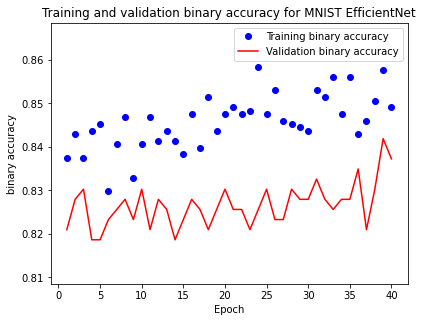

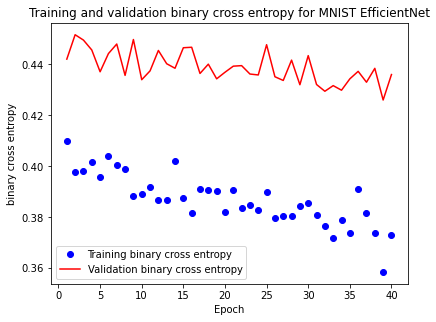

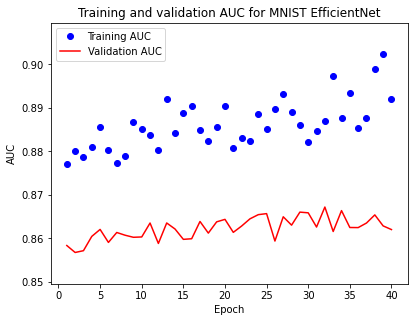

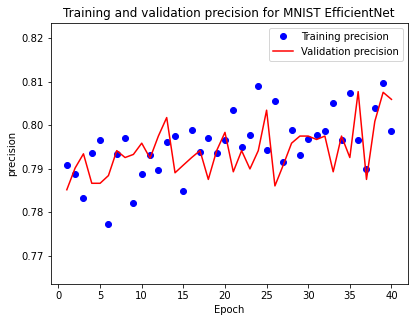

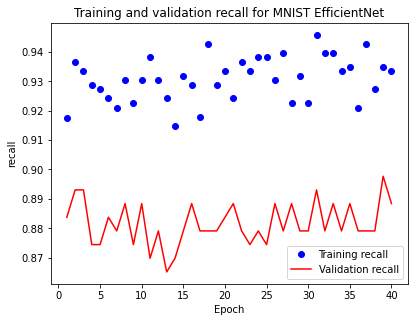

In [27]:
if compileMNISTEfficientNet:
    metricsKeysNames = zipMetricsKeysWithNames(MNISTEfficientNetB1BinaryHistory.history.keys(), metricNames)
    plotTrainingHistories(MNISTEfficientNetB1BinaryHistory, metricsKeysNames, 'MNIST EfficientNet')
    plt.show()

### 2.5.5 Function for generating aggregate multiplots from saved plot images

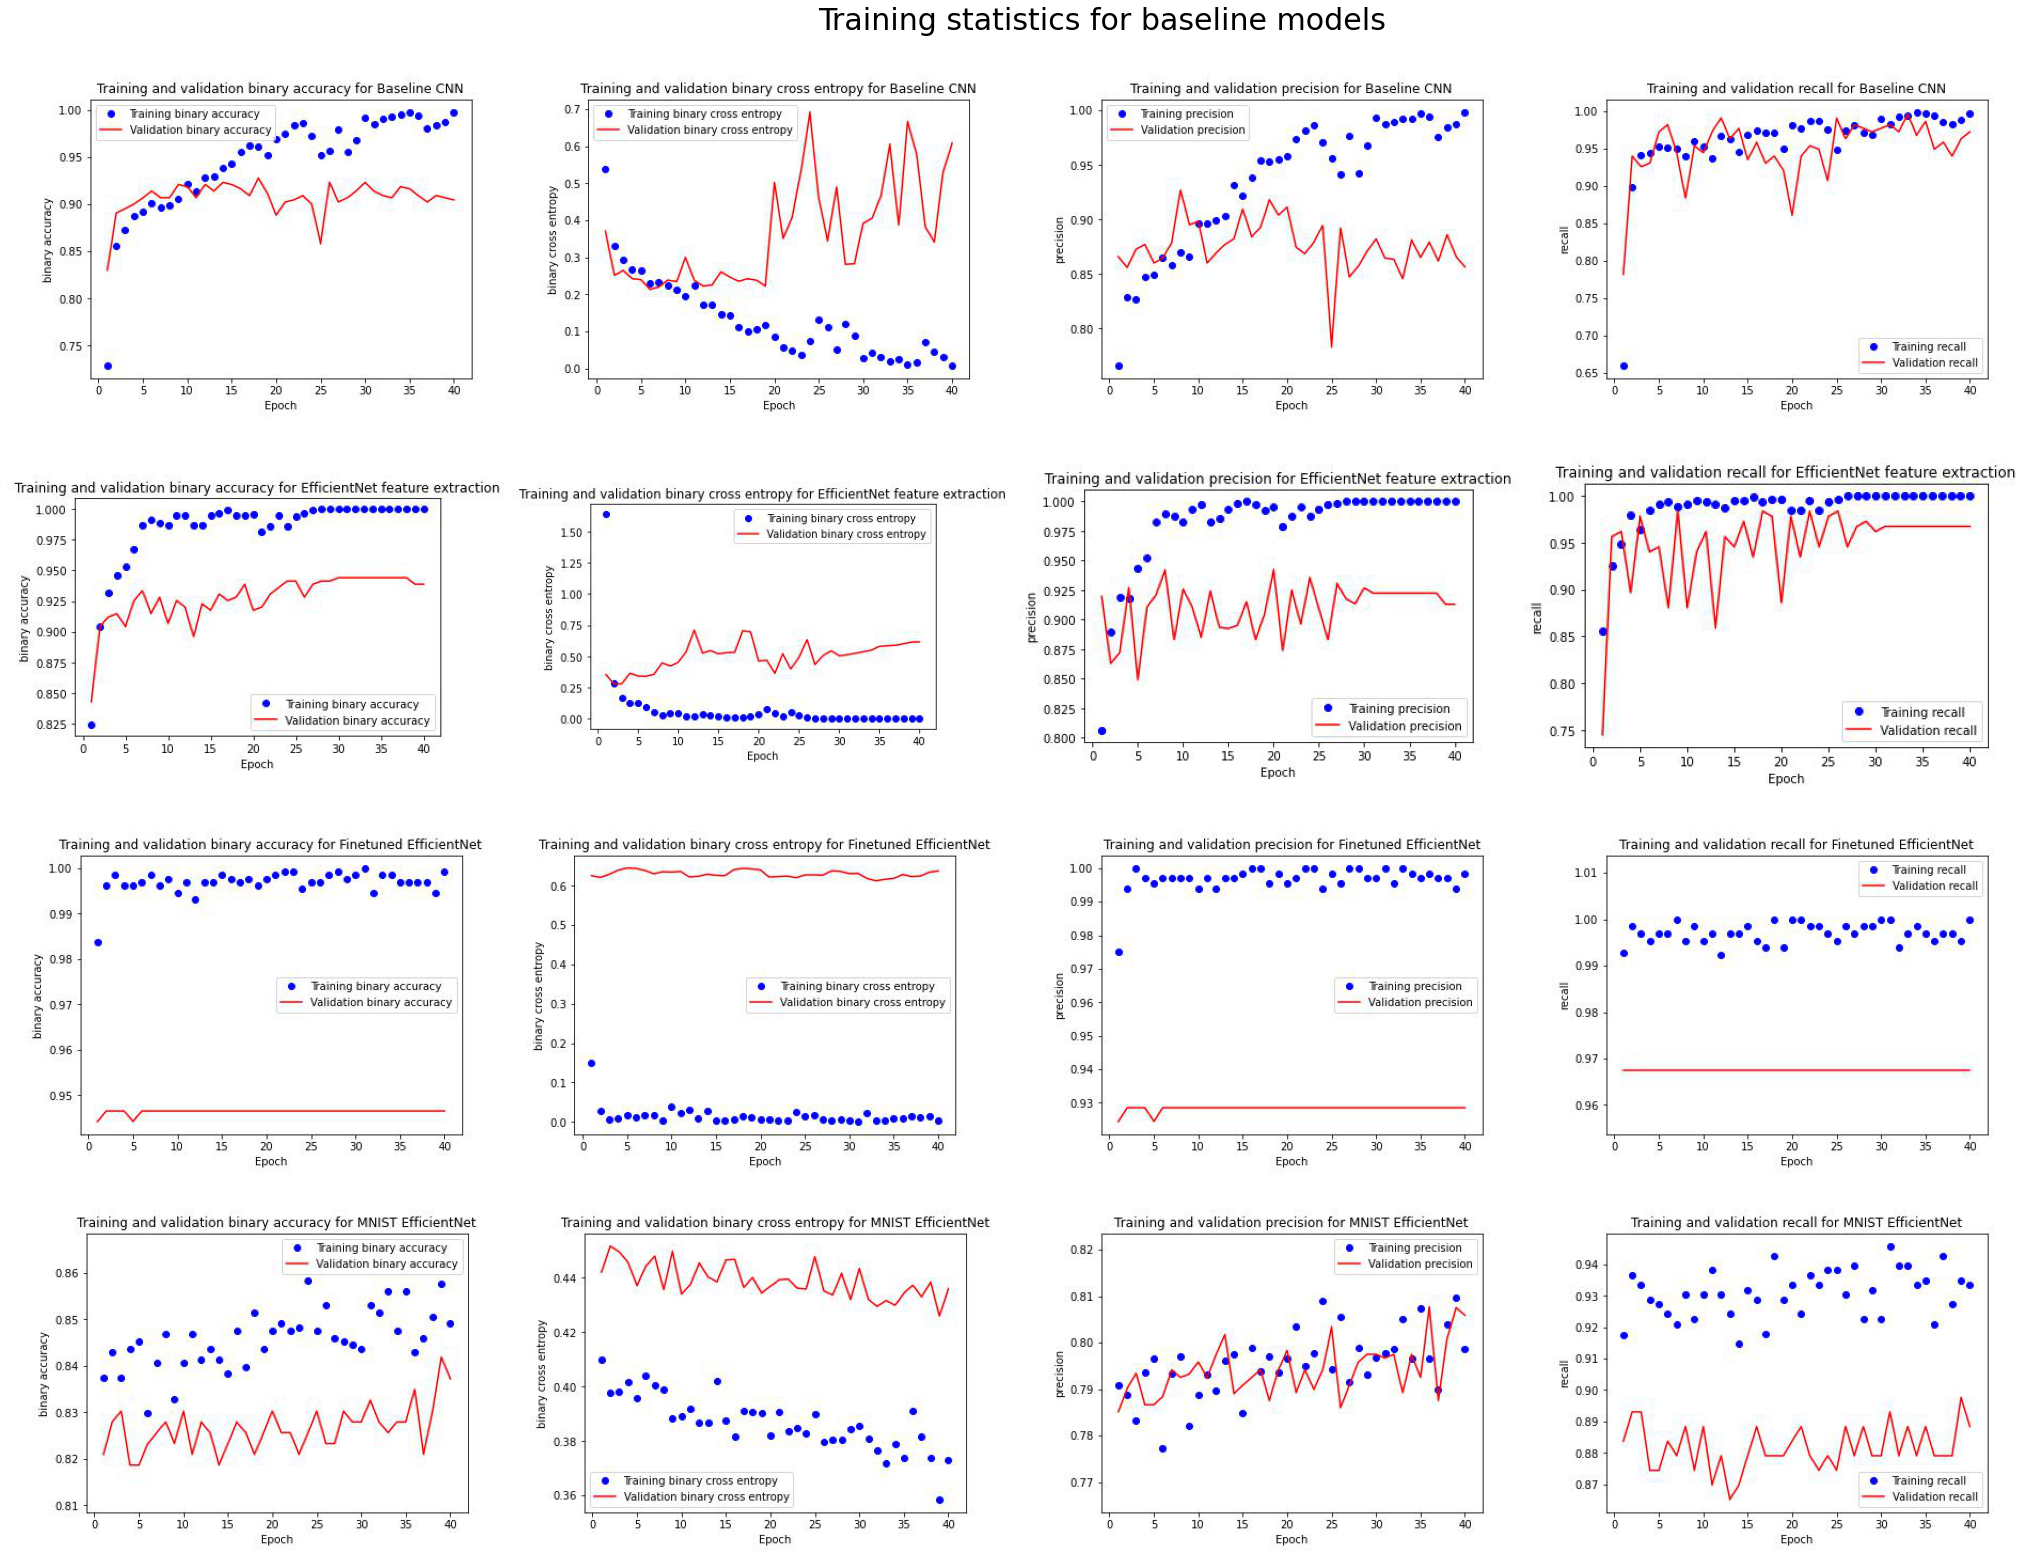

In [28]:
#
shortModelNames = ['BaselineCnn', 'EfficientNetFeatureExtraction', 'FinetunedEfficientNet', 'MNISTEfficientNet']
shortMetricNames = ['BinaryAccuracy', 'BinaryCrossEntropy', 'Precision', 'Recall']

generateMultiplot = True
#

def plotAggregateStats(shortModelNames, shortMetricNames):
    fig = plt.figure(figsize=(6.4*5, 4.8*5)) # Five times the default figure size
    plt.subplots_adjust(wspace=0.01, hspace=0.1, left=0.025, bottom=0.025)
    
    numModels = len(shortModelNames)
    numMetrics = len(shortMetricNames)

    subplotIndex = 1
    for model in shortModelNames:
        for metric in shortMetricNames:
            ax = fig.add_subplot(numModels, numMetrics, subplotIndex, frame_on=False, aspect='equal')
            graph = plt.imread(f'{model}{metric}.jpeg')
            plt.axis('off')
            plt.imshow(graph, aspect='equal')
            subplotIndex += 1
    plt.suptitle('Training statistics for baseline models', size=30., y=0.92) # y=0.94
    plt.savefig(f'AggregateTrainStats{numModels}Models{numMetrics}Metrics.jpeg')
    
if generateMultiplot:
    plotAggregateStats(shortModelNames, shortMetricNames)
    plt.show()

### 2.6 Testing the baseline models

In [29]:
print('Baseline CNN:')
baselineCNNTestScores = baselineCNN.evaluate(testDataGenerator, batch_size=batchSize, return_dict=True)
#print('EfficientNet feature extraction:')
#efficientNetFETestScores = efficientNetB1FEClassifier.evaluate(efficientNetTestDataGenerator, batch_size=batchSize, return_dict=True)
#print('Finetuned EfficientNet:')
#finetunedEfficientNetTestScores = finetunedEfficientNetB1.evaluate(efficientNetTestDataGenerator, batch_size=batchSize, return_dict=True)
print('MNIST EfficientNet:')
MNISTEfficientNetTestScores = MNISTEfficientNetB1Binary.evaluate(efficientNetTestDataGenerator, batch_size=batchSize, return_dict=True)

Baseline CNN:
6/6 [==============================] - 6s 698ms/step - loss: 0.5840 - binary_accuracy: 0.8721 - binary_crossentropy: 0.5100 - auc: 0.9192 - precision: 0.8509 - recall: 0.9023
MNIST EfficientNet:
6/6 [==============================] - 4s 600ms/step - loss: 0.3687 - binary_accuracy: 0.8488 - binary_crossentropy: 0.3687 - auc: 0.8928 - precision: 0.8099 - recall: 0.9116
